Epoch 1/50


<>:12: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:15: SyntaxWarning: invalid escape sequence '\$'
<>:12: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:15: SyntaxWarning: invalid escape sequence '\$'
C:\Users\16692\AppData\Local\Temp\ipykernel_13828\3788623593.py:12: SyntaxWarning: invalid escape sequence '\$'
  data['Close/Last'] = data['Close/Last'].replace({'\$': '', ',': ''}, regex=True).astype(float)
C:\Users\16692\AppData\Local\Temp\ipykernel_13828\3788623593.py:13: SyntaxWarning: invalid escape sequence '\$'
  data['Open'] = data['Open'].replace({'\$': '', ',': ''}, regex=True).astype(float)
C:\Users\16692\AppData\Local\Temp\ipykernel_13828\3788623593.py:14: SyntaxWarning: invalid escape sequence '\$'
  data['High'] = data['High'].replace({'\$': '', ',': ''}, regex=True).ast

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.3309 - val_loss: 0.1885
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0945 - val_loss: 0.0067
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0151 - val_loss: 0.0241
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0152 - val_loss: 0.0087
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0075 - val_loss: 0.0135
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - val_loss: 0.0049
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - val_loss: 0.0064
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 13/50


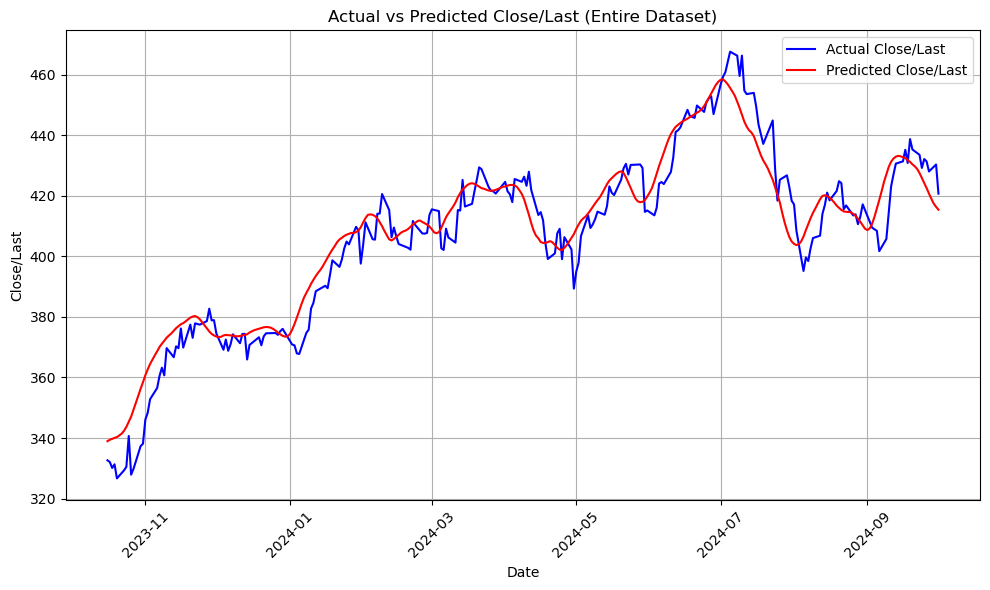

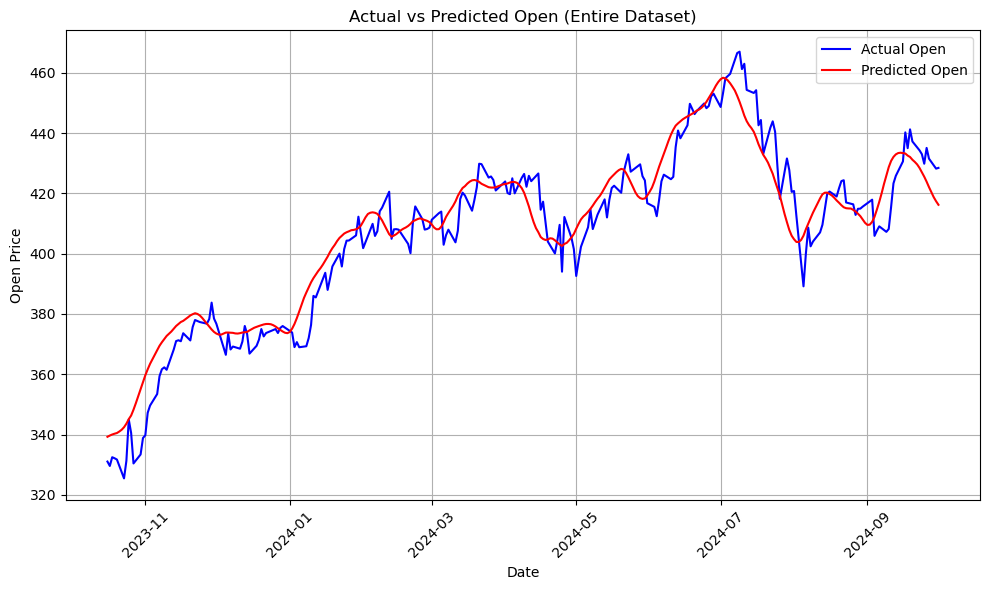

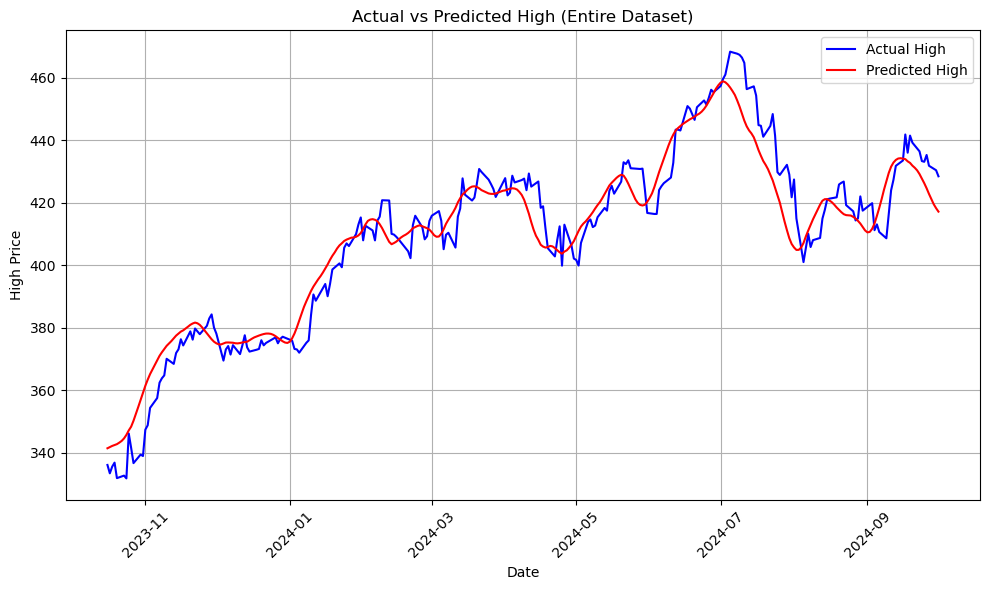

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# read csv file
data = pd.read_csv('HistoricalData_1728935814523.csv')

# Clean and convert the columns from string to float
data['Close/Last'] = data['Close/Last'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['Open'] = data['Open'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['High'] = data['High'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['Low'] = data['Low'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Create a complete date range
full_date_range = pd.date_range(start='2023-10-16', end='2024-10-11')

# Reindex the data to the full date range and interpolate missing values
data.set_index('Date', inplace=True)
data = data.reindex(full_date_range)

# Interpolate missing values
data['Volume'] = data['Volume'].interpolate(method='linear')
data['High'] = data['High'].interpolate(method='linear')
data['Low'] = data['Low'].interpolate(method='linear')
data['Open'] = data['Open'].interpolate(method='linear')
data['Close/Last'] = data['Close/Last'].interpolate(method='linear')

# After interpolation is complete, restore the Date column
data.reset_index(inplace=True)
data.rename(columns={'index': 'Date'}, inplace=True)

# Select Close/Last, Open, High for processing
data_lstm = data[['Close/Last', 'Open', 'High']]

# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_lstm)

# Create time series dataset for LSTM
def create_sequences(data, look_back=10):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 10  # We look back 10 days
X, y = create_sequences(scaled_data, look_back)

# Split the data into 11 months for training and the last month for testing
train_size = int(len(X) * (11/12))  # 11 months out of 12
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=3))  # Output three values: Close/Last, Open, High

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predict for the entire dataset (using all data)
all_data_predictions = model.predict(X)

# Inverse the normalization to return to original scale
all_data_predictions = scaler.inverse_transform(all_data_predictions)

# Ensure the predicted length matches the actual data length
min_length = min(len(data_lstm), len(all_data_predictions))

# Slice both arrays to the same length
predicted_close_last = all_data_predictions[:min_length, 0]
predicted_open = all_data_predictions[:min_length, 1]
predicted_high = all_data_predictions[:min_length, 2]

# Get actual values for comparison
actual_close_last = data_lstm['Close/Last'].values[:min_length]
actual_open = data_lstm['Open'].values[:min_length]
actual_high = data_lstm['High'].values[:min_length]

# Plot Actual vs Predicted for Close/Last (entire dataset)
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][:min_length], actual_close_last, color='blue', label='Actual Close/Last')
plt.plot(data['Date'][:min_length], predicted_close_last, color='red', label='Predicted Close/Last')
plt.title('Actual vs Predicted Close/Last (Entire Dataset)')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('close_last_prediction_all.jpg')
plt.show()

# Plot Actual vs Predicted for Open (entire dataset)
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][:min_length], actual_open, color='blue', label='Actual Open')
plt.plot(data['Date'][:min_length], predicted_open, color='red', label='Predicted Open')
plt.title('Actual vs Predicted Open (Entire Dataset)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Open_prediction_all.jpg')
plt.show()

# Plot Actual vs Predicted for High (entire dataset)
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][:min_length], actual_high, color='blue', label='Actual High')
plt.plot(data['Date'][:min_length], predicted_high, color='red', label='Predicted High')
plt.title('Actual vs Predicted High (Entire Dataset)')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('High_prediction_all.jpg')
plt.show()
